In [1]:
import csv
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import astropy
import astropy.constants as const
import pandas as pd
from scipy.integrate import simps
import scipy.stats as stats
from astropy.modeling import models, fitting

In [2]:
s2a = pd.read_csv('./resources/zprofile-2a.tsv', sep='\t', skiprows=6, header=None)
s2b = pd.read_csv('./resources/zprofile-2b.tsv', sep='\t', skiprows=6, header=None)
s2c = pd.read_csv('./resources/zprofile-2c.tsv', sep='\t', skiprows=6, header=None)

colnames = ['freq', 'intensity']
s2a.columns, s2a.name = colnames, '2a'
s2b.columns, s2b.name = colnames, '2b'
s2c.columns, s2c.name = colnames, '2c'

spec = [s2a, s2b, s2c]

In [3]:
norm = lambda x, c=1: x / simps(x) * c

In [4]:
datadist = spec[2].intensity
sampdist = norm(stats.norm.pdf(spec[2].freq, loc=spec[2].freq.mean(), scale=spec[2].freq.std()*1.25), .05)

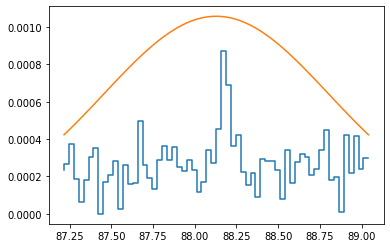

In [5]:
plt.step(spec[2].freq, datadist - min(datadist))
plt.plot(spec[2].freq, sampdist)

In [554]:
def rej_samp(xvals, samp_dist, target_dist, n):
    xval_idx = np.arange(len(xvals))
    x_idx = np.random.choice(xval_idx, p=(samp_dist / samp_dist.sum()), size=5*n)
    highy = samp_dist[x_idx]
    geny = np.random.uniform(min(target_dist), highy)
    limity = target_dist[x_idx]
    mask = geny <= limity
    return xvals[limity.index[mask]].values, geny[mask]

In [555]:
g_init = models.Gaussian1D(amplitude=max(spec[2].intensity), mean=88, stddev=.3, bounds={'mean': (88, 88.5)})
fit_g = fitting.LevMarLSQFitter()

In [556]:
n = 100
means, stds, fluxes = np.zeros(n), np.zeros(n), np.zeros(n)
all_xs, all_ys = [], []
for idx in range(n):
    x, y = rej_samp(spec[2].freq, sampdist, datadist, len(datadist))
    xs = np.zeros(len(np.unique(x)))
    ys = np.zeros(len(np.unique(x)))
    for i, j in enumerate(np.unique(x)):
        xs[i] = j
        ys[i] = y[x == j].max()
    g = fit_g(g_init, xs, ys)
    if min(spec[2].freq) < g.mean.value < max(spec[2].freq):
        all_xs.append(xs)
        all_ys.append(ys)
        means[idx] = g.mean.value
        stds[idx] = g.stddev.value
        fluxes[idx] = simps(ys)

In [557]:
means[means.nonzero()].mean(), means[means.nonzero()].std()

(88.28663379528014, 0.21644822989793402)

In [558]:
stds[stds.nonzero()].mean(), stds[stds.nonzero()].std()

(0.4781176045471725, 0.9487467143839025)

In [559]:
fluxes.mean(), fluxes.std()

(-0.001885839646203711, 0.0007017220660227841)

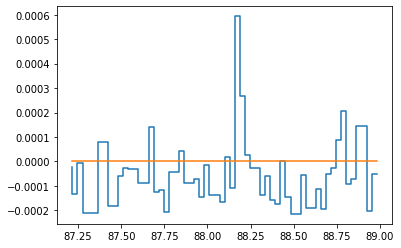

In [560]:
plt.step(xs, ys)
plt.plot(xs, g(xs))

In [329]:
# plt.figure(figsize=(16, 12))
# for x, y in zip(all_xs, all_ys):
#     plt.plot(x, y, alpha=0.1)

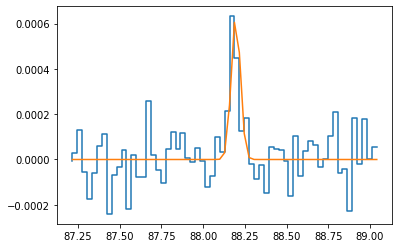

In [494]:
plt.step(spec[2].freq, spec[2].intensity)
plt.plot(spec[2].freq, fit_g(g_init, spec[2].freq, spec[2].intensity)(spec[2].freq))